**Import Libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn import svm
import csv
import cv2
import imageio

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageOps
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

In [2]:
image_filenames = [i for i in os.listdir('UTKFace/')]

**Reading the images**

In [3]:
ages=[]
# Iterate throuigh the filenames and for each one load the image, resize and normalise
count = len(image_filenames)
images=[]
for i, image_file in enumerate(image_filenames):
        age=image_file.split('_')[0]
        #image = imageio.imread('UTKFace/'+image_file)
        image= cv2.imread('UTKFace/'+image_file,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (200,200), interpolation=cv2.INTER_CUBIC)        
        if i%10000==0:
            print('Processed {} of {} images'.format(i + 1, count))
        ages.append(int(age))
        images.append(image)

Processed 1 of 23708 images
Processed 10001 of 23708 images
Processed 20001 of 23708 images


# Data Visualisation

**Age 16-25**

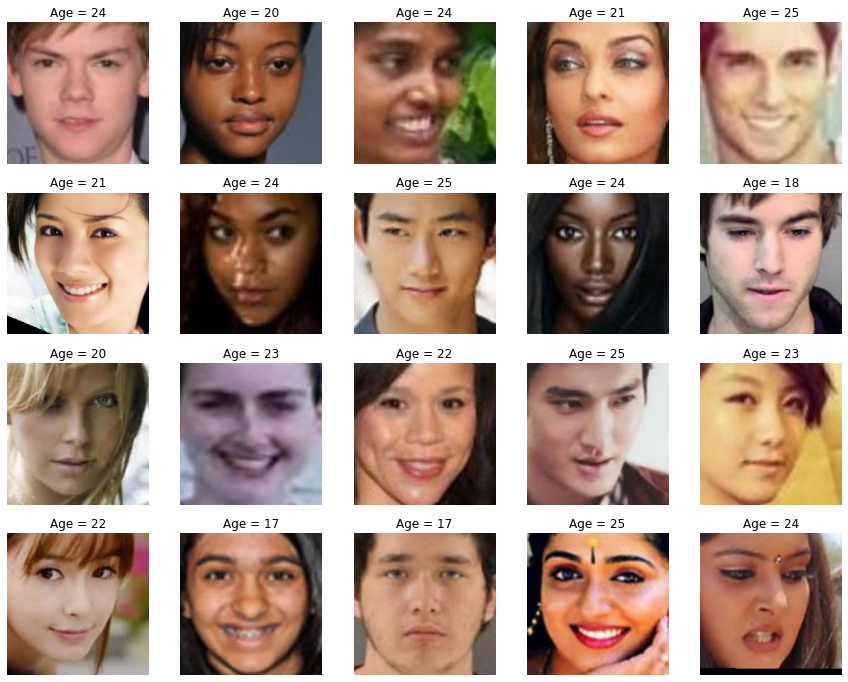

In [21]:
pltsize=3
row_images = 4
col_images = 5

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i, image_file in enumerate(image_filenames):
    rand =random.randint(0,len(image_filenames))
    age=int(image_filenames[rand].split('_')[0])
    if ii>=maxtoshow:
        break
    if age>16 and age <=25:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(images[rand])
        ii = ii + 1
        plt.title("Age = {}".format(age))

**Age 26 - 35**

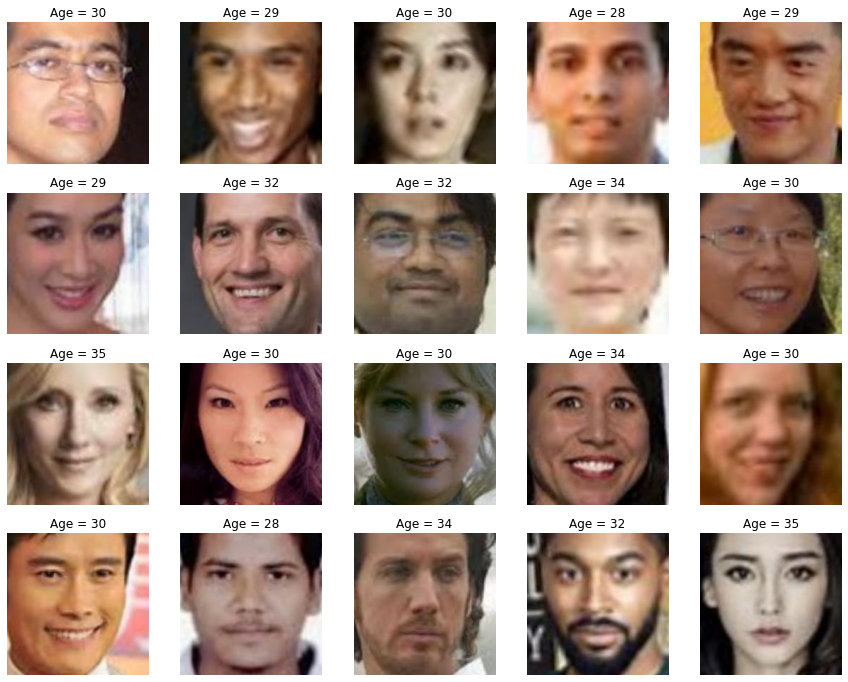

In [24]:
pltsize=3
row_images = 4
col_images = 5

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i, image_file in enumerate(image_filenames):
    rand =random.randint(0,len(image_filenames))
    age=int(image_filenames[rand].split('_')[0])
    if ii>=maxtoshow:
        break
    if age>26 and age <=35:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(images[rand])
        ii = ii + 1
        plt.title("Age = {}".format(age))

**Age 36-45**

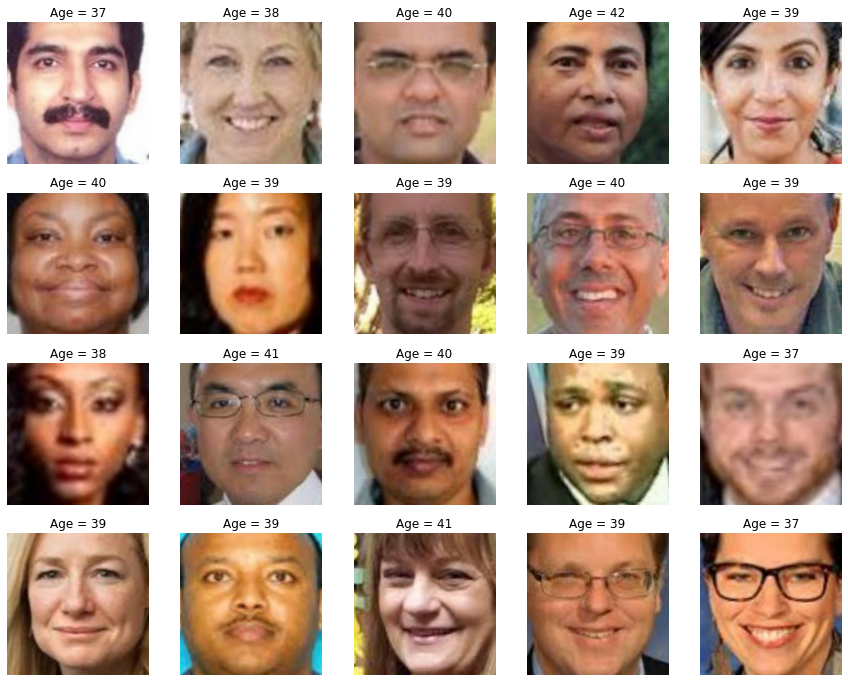

In [27]:
pltsize=3
row_images = 4
col_images = 5

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i, image_file in enumerate(image_filenames):
    rand =random.randint(0,len(image_filenames))
    age=int(image_filenames[rand].split('_')[0])
    if ii>=maxtoshow:
        break
    if age>36 and age <=42:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(images[rand])
        ii = ii + 1
        plt.title("Age = {}".format(age))

**Age 43-50**

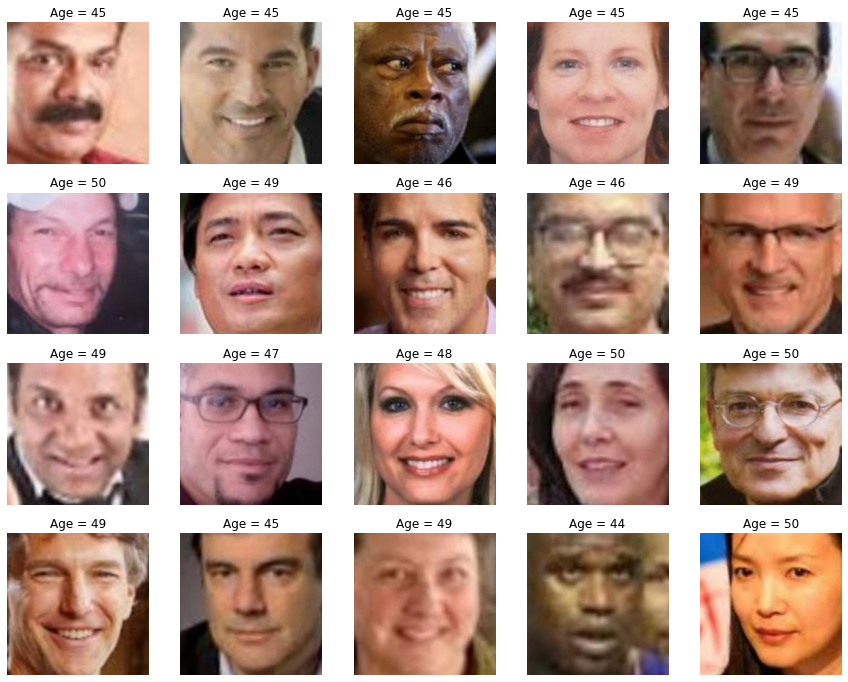

In [28]:
pltsize=3
row_images = 4
col_images = 5

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i, image_file in enumerate(image_filenames):
    rand =random.randint(0,len(image_filenames))
    age=int(image_filenames[rand].split('_')[0])
    if ii>=maxtoshow:
        break
    if age>43 and age <=50:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(images[rand])
        ii = ii + 1
        plt.title("Age = {}".format(age))

**Assign data to dataframe**

In [4]:
#Convert to series
images_list = pd.Series(list(images),name='Images')
ages_list = pd.Series(list(ages),name='Age')
df = pd.concat([images_list, ages_list],axis=1)
df.head()

Images  Age
0  [[[215, 206, 201], [213, 204, 199], [212, 203,...  100
1  [[[118, 122, 133], [120, 124, 135], [122, 126,...  100
2  [[[219, 223, 226], [232, 235, 240], [232, 237,...  100
3  [[[78, 82, 93], [78, 82, 93], [78, 82, 93], [7...  100
4  [[[65, 69, 80], [66, 70, 81], [67, 71, 82], [6...  100

**Storing images to an array**

In [5]:
X = []
for i in range(len(df)):
    img = np.asarray(df['Images'].iloc[i])
    X.append(img)
X = np.array(X)

**Train test split**

In [6]:
y_age = df['Age']
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(X, y_age, test_size=0.2)

In [7]:
#Convert to series
images_list = pd.Series(list(x_train_age),name='Images')
ages_list = pd.Series(list(y_train_age),name='Age')
df = pd.concat([images_list, ages_list],axis=1)
df.head()

Images  Age
0  [[[76, 29, 9], [65, 19, 3], [52, 12, 0], [46, ...   21
1  [[[29, 28, 26], [29, 28, 26], [29, 27, 28], [2...   21
2  [[[15, 0, 0], [16, 1, 0], [17, 2, 0], [19, 4, ...   26
3  [[[185, 153, 140], [185, 153, 140], [185, 153,...   24
4  [[[126, 97, 79], [130, 101, 83], [138, 107, 89...   68

**Preprocessing after train test split to avoid peeking**

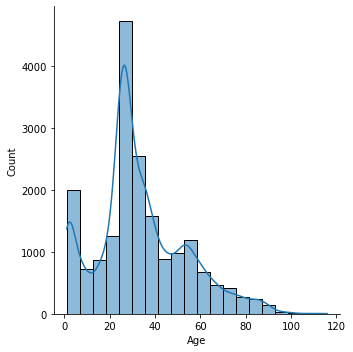

In [8]:
sns.displot(df['Age'],kde=True,bins=20)

It is observed that the age group of 26 has high counts , the model can perform best for this age group ,hence we try to take a small sample out 

In [9]:
midtwentys = []

for i in range(len(df)):
    if df['Age'].iloc[i] == 26:
        midtwentys.append(df.iloc[i])
midtwentys = pd.DataFrame(midtwentys)
midtwentys = midtwentys.sample(frac=0.3)

In [10]:
len(midtwentys)

531

In [11]:
df = df[df['Age']!=26]
df = pd.concat([df, midtwentys], ignore_index = True)
df.shape

(17727, 2)

In [12]:
df['Age'].value_counts().head(5)

1     900
28    739
35    716
24    681
25    582
Name: Age, dtype: int64

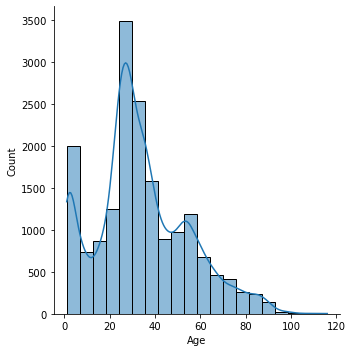

In [13]:
sns.displot(df['Age'],kde=True,bins=20)

We also see there is a large number of images with 1 year old babies. We can take a sample of those images.

In [14]:
ageone = []

for i in range(len(df)):
    if df['Age'].iloc[i] ==1:
        ageone.append(df.iloc[i])
ageone = pd.DataFrame(ageone)
ageone = ageone.sample(frac=0.4)
df = df[df['Age']!=1]
df = pd.concat([df, ageone], ignore_index = True)
df.shape

(17187, 2)

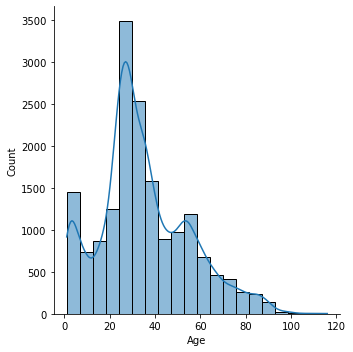

In [15]:
sns.displot(df['Age'],kde=True,bins=20)

The distribution plot looks better now

In [16]:
X_train_age = []
for i in range(len(df)):
    img = np.asarray(df['Images'].iloc[i])
    X_train_age.append(img)
X_train_age = np.array(X_train_age)

In [17]:
y_train_age = df['Age']

# Model Creation

**Creating model For Age-Trial 1**

In [23]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('input_units',
                                min_value=32,
                                max_value=50), (3, 3),input_shape=(200,200, 3)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    for i in range(hp.Int('n_layers', 2, 4)): 
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=150), (2, 2)))
        model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation("relu"))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(Adam(learning_rate=hp_learning_rate),loss='mae',
        metrics=['mae'])

    return model

In [24]:
tuner = RandomSearch(
    build_model,
    objective='mae',
    max_trials=4,
    executions_per_trial=1,
    directory='age',
    project_name='age prediction')

In [25]:
datagen = ImageDataGenerator(rescale = 1./255,width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train = datagen.flow(X_train_age, y_train_age, batch_size=128)

test = test_datagen.flow(x_test_age, y_test_age,batch_size=128)

In [26]:
tuner.search(train,
             epochs=6,
             validation_data=(test))

Trial 4 Complete [00h 50m 44s]
mae: 13.778636932373047

Best mae So Far: 13.297425270080566
Total elapsed time: 03h 35m 18s
INFO:tensorflow:Oracle triggered exit


In [29]:
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 35)      980       
_________________________________________________________________
activation (Activation)      (None, 198, 198, 35)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 35)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 34)        4794      
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 34)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 141)       19317     
_________________________________________________________________
activation_2 (Activation)    (None, 97, 97, 141)       0

In [27]:
tuner.get_best_hyperparameters()[0].values

{'input_units': 35,
 'n_layers': 3,
 'conv_0_units': 34,
 'conv_1_units': 141,
 'learning_rate': 0.0001,
 'conv_2_units': 137,
 'conv_3_units': 125}

In [32]:
best_model = Sequential()
best_model.add(Conv2D(35, (3,3), input_shape=(200,200, 3)))
best_model.add(Activation('relu'))
best_model.add(MaxPooling2D(pool_size=(2, 2)))

best_model.add(Conv2D(34, (2,2)))
best_model.add(Activation('relu'))

best_model.add(Conv2D(141, (2,2)))
best_model.add(Activation('relu'))

best_model.add(Conv2D(137, (2,2)))
best_model.add(Activation('relu'))

best_model.add(Dropout(0.25))
best_model.add(Flatten())
best_model.add(Dense(64))
best_model.add(Activation('relu'))
best_model.add(Dropout(0.5))
best_model.add(Dense(1))
best_model.add(Activation("linear"))

best_model.compile(Adam(learning_rate=0.0001),loss='mae',
             metrics=['mae'])
best_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 198, 198, 35)      980       
_________________________________________________________________
activation_19 (Activation)   (None, 198, 198, 35)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 99, 99, 35)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 98, 98, 34)        4794      
_________________________________________________________________
activation_20 (Activation)   (None, 98, 98, 34)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 97, 97, 141)       19317     
_________________________________________________________________
activation_21 (Activation)   (None, 97, 97, 141)      

In [33]:
historyage = best_model.fit(train, epochs=60, shuffle=True, validation_data=test)

Epoch 1/60
135/135 [==============================] - 656s 5s/step - loss: 17.2504 - mae: 17.2504 - val_loss: 15.3274 - val_mae: 15.3274
Epoch 2/60
135/135 [==============================] - 650s 5s/step - loss: 14.7329 - mae: 14.7329 - val_loss: 12.6815 - val_mae: 12.6815
Epoch 3/60
135/135 [==============================] - 651s 5s/step - loss: 13.8026 - mae: 13.8026 - val_loss: 11.9531 - val_mae: 11.9531
Epoch 4/60
135/135 [==============================] - 655s 5s/step - loss: 13.4514 - mae: 13.4514 - val_loss: 11.6870 - val_mae: 11.6870
Epoch 5/60
135/135 [==============================] - 652s 5s/step - loss: 13.2806 - mae: 13.2806 - val_loss: 12.1701 - val_mae: 12.1701
Epoch 6/60
135/135 [==============================] - 650s 5s/step - loss: 13.0778 - mae: 13.0778 - val_loss: 11.7437 - val_mae: 11.7437
Epoch 7/60
135/135 [==============================] - 653s 5s/step - loss: 12.9989 - mae: 12.9989 - val_loss: 10.8907 - val_mae: 10.8907
Epoch 8/60
135/135 [=====================

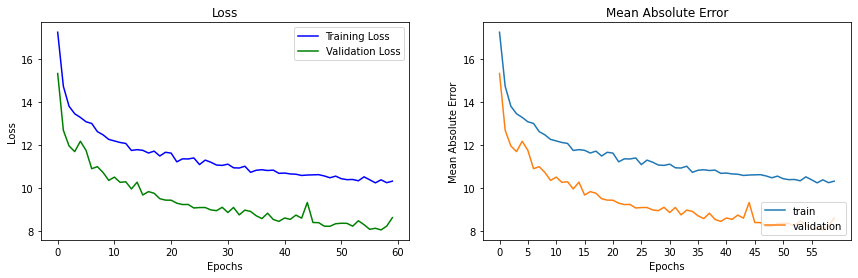

In [40]:
plt.subplots_adjust(left=None, bottom=None, right = 2, top=None, wspace=None, hspace=None)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
loss = historyage.history['loss']
val_loss = historyage.history['val_loss']
epochs=60
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2) # index 2
plt.plot(historyage.history['mae'])
plt.plot(historyage.history['val_mae'])
plt.title('Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.xticks(range(0,epochs)[0::5])
plt.legend(['train', 'validation'], loc='lower right')

**Evaluation for age model**

In [34]:
y_pred_age=[]

In [36]:
for i in x_test_age:
    i=i/255
    i=i.reshape(-1,200,200,3)
    y_pred_age.append(int(best_model.predict(i)))

In [37]:
y_pred_age=np.asarray(y_pred_age).astype(int)

In [38]:
y_pred_age

array([37, 44, 29, ..., 37, 42, 18])

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mse = mean_squared_error(y_test_age, y_pred_age, squared=False)
r2=r2_score(y_test_age, y_pred_age)
print('MSE=',np.round(mse,2))
print('R-squared',r2)

MSE= 11.38
R-squared 0.6742028756112444


**Trial 2**

In [18]:
model = Sequential()   
model.add(Conv2D(32, (3, 3), input_shape =(200,200,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))#Output layer
model.add(Activation('relu'))
model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='mse', 
                  metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 97, 97, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 97, 97, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0

In [19]:
datagen = ImageDataGenerator(rescale = 1./255,width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train = datagen.flow(X_train_age, y_train_age, batch_size=32)

test = test_datagen.flow(x_test_age, y_test_age,batch_size=32)

In [20]:
historyage = model.fit(train, epochs=60, shuffle=True, validation_data=test)

Epoch 1/60
538/538 [==============================] - 357s 662ms/step - loss: 338.9575 - mae: 14.1216 - val_loss: 277.7050 - val_mae: 12.5672
Epoch 2/60
538/538 [==============================] - 355s 659ms/step - loss: 275.0634 - mae: 12.7439 - val_loss: 203.9079 - val_mae: 11.4006
Epoch 3/60
538/538 [==============================] - 353s 657ms/step - loss: 261.5205 - mae: 12.3316 - val_loss: 151.2912 - val_mae: 9.4952
Epoch 4/60
538/538 [==============================] - 354s 657ms/step - loss: 246.8504 - mae: 11.9715 - val_loss: 160.7074 - val_mae: 9.4208
Epoch 5/60
538/538 [==============================] - 352s 655ms/step - loss: 240.5801 - mae: 11.7291 - val_loss: 140.6551 - val_mae: 9.0782
Epoch 6/60
538/538 [==============================] - 353s 656ms/step - loss: 228.0071 - mae: 11.4239 - val_loss: 161.3362 - val_mae: 9.9568
Epoch 7/60
538/538 [==============================] - 353s 657ms/step - loss: 217.4530 - mae: 11.1708 - val_loss: 140.2919 - val_mae: 8.9652
Epoch 8/60


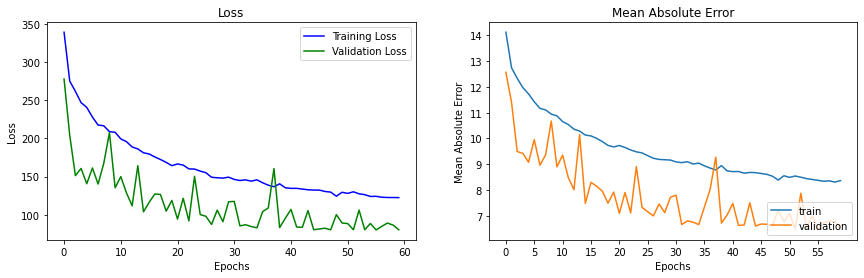

In [21]:
plt.subplots_adjust(left=None, bottom=None, right = 2, top=None, wspace=None, hspace=None)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
loss = historyage.history['loss']
val_loss = historyage.history['val_loss']
epochs=60
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2) # index 2
plt.plot(historyage.history['mae'])
plt.plot(historyage.history['val_mae'])
plt.title('Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.xticks(range(0,epochs)[0::5])
plt.legend(['train', 'validation'], loc='lower right')

**Evaluation for age model**

In [22]:
y_pred_age=[]

In [24]:
for i in x_test_age:
    i=i/255
    i=i.reshape(-1,200,200,3)
    y_pred_age.append(int(model.predict(i)))

In [25]:
y_pred_age=np.asarray(y_pred_age).astype(int)

In [26]:
y_pred_age

array([ 0,  0, 22, ..., 24,  0, 29])

In [31]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
mse = mean_squared_error(y_test_age, y_pred_age, squared=False)
mae = mean_absolute_error(y_test_age, y_pred_age)
r2=r2_score(y_test_age, y_pred_age)
print('MSE=',np.round(mse,2))
print('R-squared-',r2)
print('Mean absolute error=',mae)

MSE= 9.07
R-squared- 0.8010737252571554
Mean absolute error= 6.556516237874314


In [32]:
from sklearn.metrics import mean_absolute_percentage_error
print('MAPE=',mean_absolute_percentage_error(y_test_age, y_pred_age))

MAPE= 0.3496866237259245


MAPE value of 34% means that the average difference between the forecasted value and the actual value is 34%.

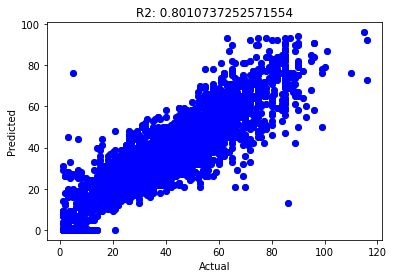

In [136]:
fig, ax = plt.subplots()
ax.scatter(y_test_age,y_pred_age)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.scatter(y_test_age,y_pred_age,color='blue')
ax.set_title('R2: ' + str(r2_score(y_test_age,y_pred_age)))
plt.show()

In [37]:
y_test_age=np.array(y_test_age)
y_test_age

array([ 1,  4, 12, ..., 22,  2, 28], dtype=int64)

**Correct predictions**

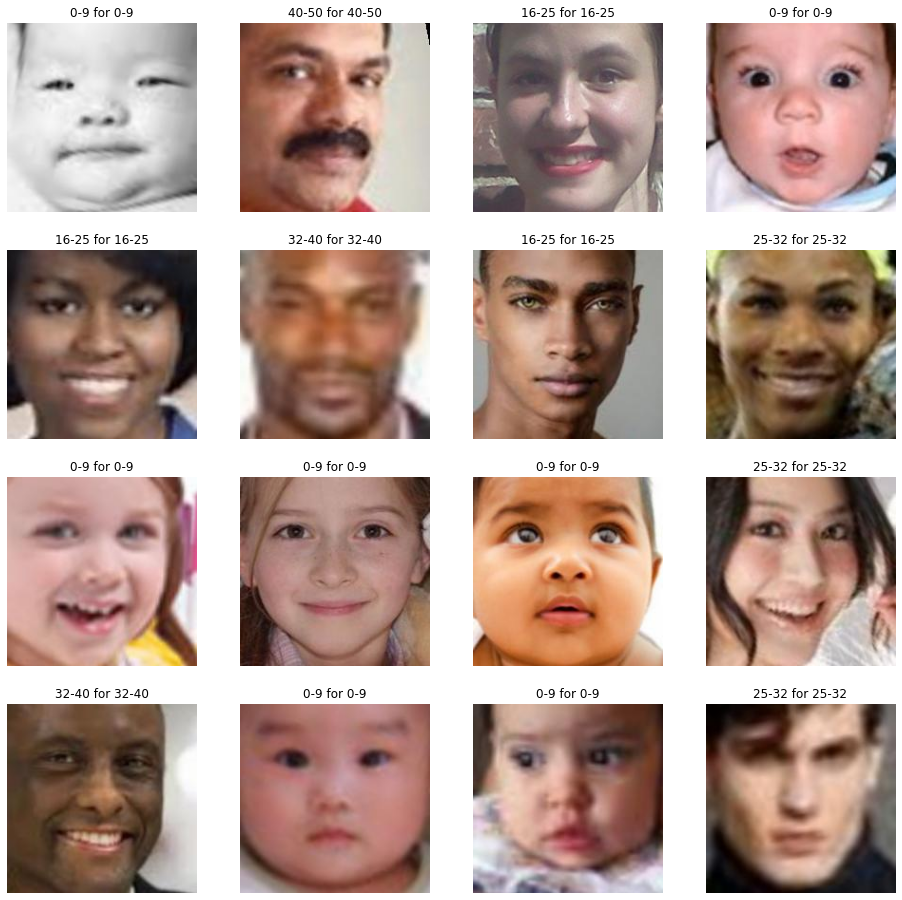

In [55]:
import PIL
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(x_test_age.shape[0]):
    rand =random.randint(0,x_test_age.shape[0])
    if ii>=maxtoshow:
        break
    if y_pred_age[rand] in range(10,16) and y_test_age[rand] in range(10,16) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("10-16 for 10-16")
        ii = ii + 1
    if y_pred_age[rand] in range(0,10) and y_test_age[rand] in range(0,10) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("0-9 for 0-9")
        ii = ii + 1
    if y_pred_age[rand] in range(16,25) and y_test_age[rand] in range(16,25) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("16-25 for 16-25")
        ii = ii + 1
    if y_pred_age[rand] in range(25,32) and y_test_age[rand] in range(25,32) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("25-32 for 25-32")
        ii = ii + 1
    if y_pred_age[rand] in range(32,40) and y_test_age[rand] in range(32,40) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("32-40 for 32-40")
        ii = ii + 1
    if y_pred_age[rand] in range(40,50) and y_test_age[rand] in range(40,50) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("40-50 for 40-50")
        ii = ii + 1

**Incorrect Predictions**

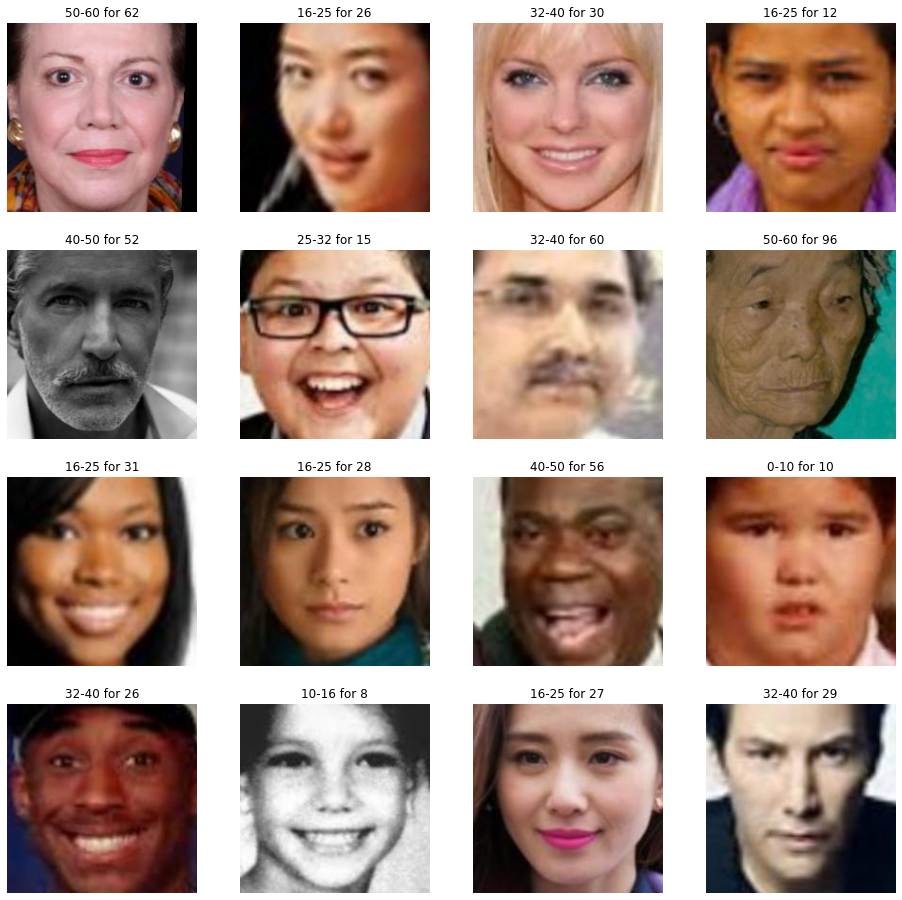

In [134]:
import PIL
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(x_test_age.shape[0]):
    rand =random.randint(0,x_test_age.shape[0])
    if ii>=maxtoshow:
        break
    if y_pred_age[rand] in range(10,16) and y_test_age[rand] not in range(10,16) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("10-16 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] in range(0,10) and y_test_age[rand] not in range(0,10) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("0-10 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] in range(16,25) and y_test_age[rand] not in range(16,25) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("16-25 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] in range(25,32) and y_test_age[rand] not in range(25,32) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("25-32 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] in range(32,40) and y_test_age[rand] not in range(32,40) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("32-40 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] in range(40,50) and y_test_age[rand] not in range(40,50) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("40-50 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] in range(50,60) and y_test_age[rand] not in range(50,60) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("50-60 for {}".format(y_test_age[rand]))
        ii = ii + 1

**Checking the number of predictions for different age group and actual test data**

In [85]:
predclasses = []
for i in y_pred_age:
    i = int(i)
    if i < 7:
        predclasses.append('0-7')
    elif (i>=7) and (i<14):
        predclasses.append('7-14')
    elif (i>=14) and (i<21):
        predclasses.append('14-21')
    elif (i>=21) and (i<28):
        predclasses.append('21-28')
    elif (i>=28) and (i<36):
        predclasses.append('28-36')
    elif (i>=36) and (i<42):
        predclasses.append('36-42')
    elif (i>=42) and (i<50):
        predclasses.append('42-50')
    elif (i>=50) and (i<60):
        predclasses.append('50-60')
    else:
        predclasses.append('60-100')
        
actualclasses=[]
for i in y_test_age:
    i = int(i)
    if i < 7:
        actualclasses.append('0-7')
    elif (i>=7) and (i<14):
        actualclasses.append('7-14')
    elif (i>=14) and (i<21):
        actualclasses.append('14-21')
    elif (i>=21) and (i<28):
        actualclasses.append('21-28')
    elif (i>=28) and (i<36):
        actualclasses.append('28-36')
    elif (i>=36) and (i<42):
        actualclasses.append('36-42')
    elif (i>=42) and (i<50):
        actualclasses.append('42-50')
    elif (i>=50) and (i<60):
        actualclasses.append('50-60')
    else:
        actualclasses.append('60-100')

In [93]:
from collections import Counter
predictions={}
predictions=Counter(predclasses)
test=Counter(actualclasses)

In [94]:
preddf = pd.DataFrame.from_records(list(dict(predictions).items()), columns=['predclasses','predcount'])
actualdf = pd.DataFrame.from_records(list(dict(test).items()), columns=['actualclasses','actualcount'])

<AxesSubplot:xlabel='actualclasses'>

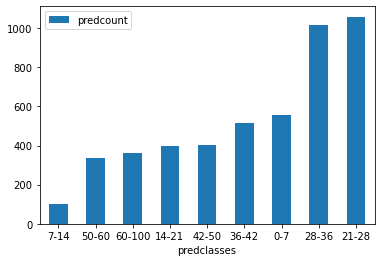

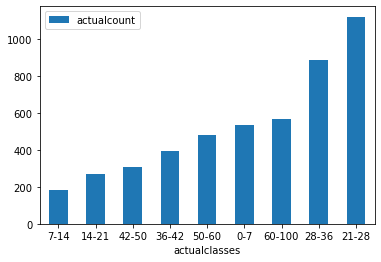

In [97]:
preddf.sort_values("predcount").plot.bar(x='predclasses',y='predcount',rot=0)
actualdf.sort_values("actualcount").plot.bar(x='actualclasses',y='actualcount',rot=0)

**Saving Model**

In [137]:
model.save('age_model.h5')

**Reading model and checking the predictions again**

In [19]:
from keras.models import load_model
agemodel=load_model(r'age_model.h5')

In [20]:
y_pred_age=[]

In [21]:
for i in x_test_age:
    i=i/255
    i=i.reshape(-1,200,200,3)
    y_pred_age.append(int(agemodel.predict(i)))

In [22]:
y_pred_age=np.asarray(y_pred_age).astype(int)

In [23]:
y_pred_age

array([22, 67, 62, ..., 26, 79, 44])

In [24]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
mse = mean_squared_error(y_test_age, y_pred_age, squared=False)
mae = mean_absolute_error(y_test_age, y_pred_age)
r2=r2_score(y_test_age, y_pred_age)
print('MSE=',np.round(mse,2))
print('R-squared-',r2)
print('Mean absolute error=',mae)

MSE= 8.34
R-squared- 0.8236920634218773
Mean absolute error= 6.183045128637706


In [25]:
from sklearn.metrics import mean_absolute_percentage_error
print('MAPE=',mean_absolute_percentage_error(y_test_age, y_pred_age))

MAPE= 0.3355789511987985


MAPE value of 34% means that the average difference between the forecasted value and the actual value is 34%.

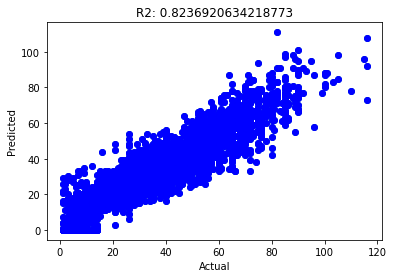

In [26]:
fig, ax = plt.subplots()
ax.scatter(y_test_age,y_pred_age)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.scatter(y_test_age,y_pred_age,color='blue')
ax.set_title('R2: ' + str(r2_score(y_test_age,y_pred_age)))
plt.show()

In [27]:
y_test_age=np.array(y_test_age)
y_test_age

array([28, 64, 61, ..., 26, 76, 39], dtype=int64)

**Correct predictions**

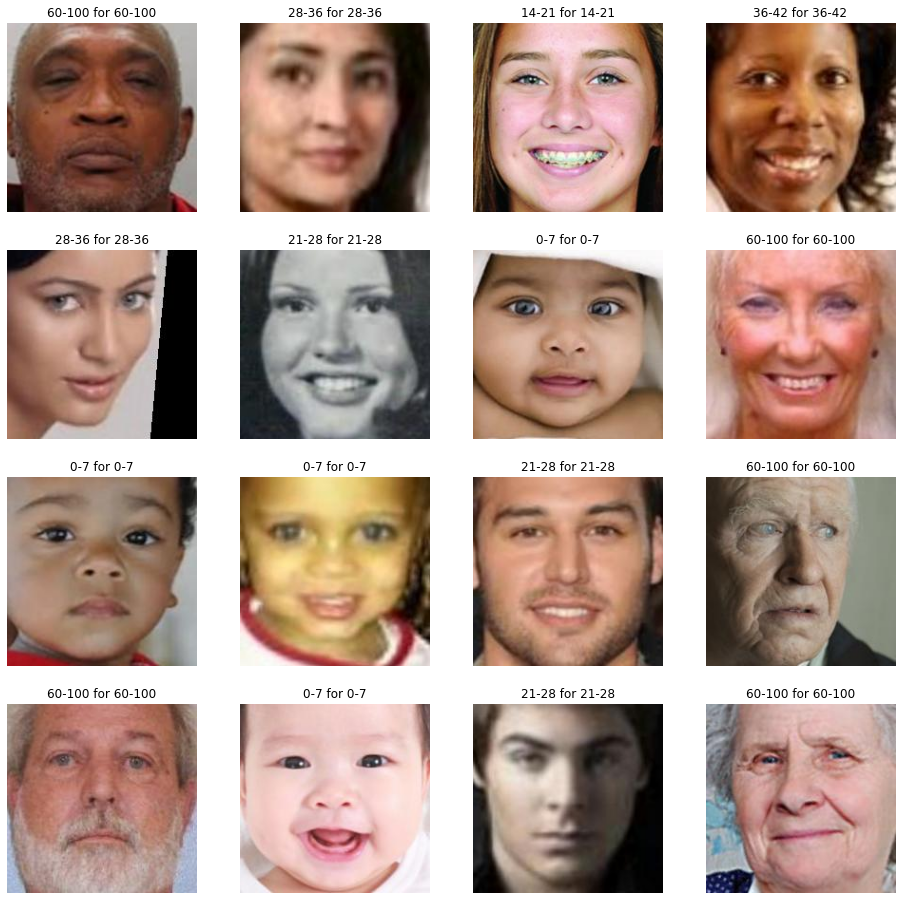

In [28]:
import PIL
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(x_test_age.shape[0]):
    rand =random.randint(0,x_test_age.shape[0])
    if ii>=maxtoshow:
        break
    if y_pred_age[rand] <7 and y_test_age[rand] <7 :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("0-7 for 0-7")
        ii = ii + 1
    if y_pred_age[rand] in range(7,14) and y_test_age[rand] in range(7,14) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("7-14 for 7-14")
        ii = ii + 1
    if y_pred_age[rand] in range(14,21) and y_test_age[rand] in range(14,21) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("14-21 for 14-21")
        ii = ii + 1
    if y_pred_age[rand] in range(21,28) and y_test_age[rand] in range(21,28) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("21-28 for 21-28")
        ii = ii + 1
    if y_pred_age[rand] in range(28,36) and y_test_age[rand] in range(28,36) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("28-36 for 28-36")
        ii = ii + 1
    if y_pred_age[rand] in range(36,42) and y_test_age[rand] in range(36,42) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("36-42 for 36-42")
        ii = ii + 1
    if y_pred_age[rand] in range(42,50) and y_test_age[rand] in range(42,50) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("42-50 for 42-50")
        ii = ii + 1
    if y_pred_age[rand] in range(50,60) and y_test_age[rand] in range(50,60) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("50-60 for 50-60")
        ii = ii + 1
    if y_pred_age[rand] in range(60,100) and y_test_age[rand] in range(60,100) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("60-100 for 60-100")
        ii = ii + 1

**Incorrect Predictions**

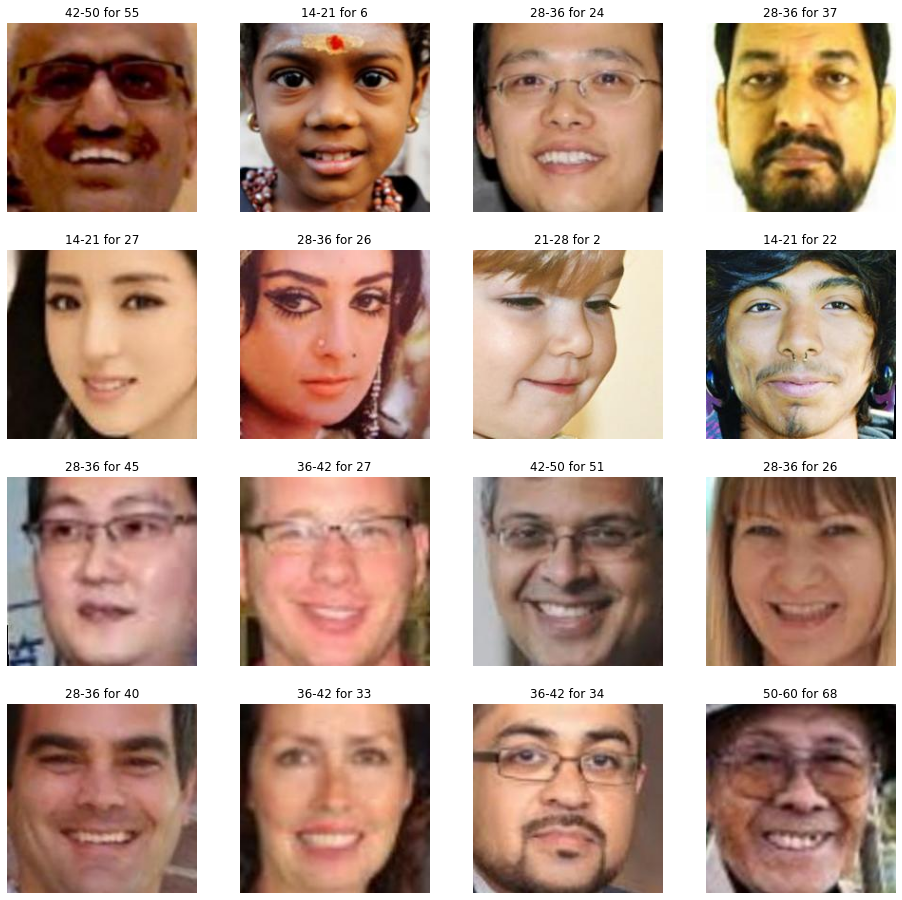

In [44]:
import PIL
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(x_test_age.shape[0]):
    rand =random.randint(0,x_test_age.shape[0])
    if ii>=maxtoshow:
        break
    if y_pred_age[rand] <7 and y_test_age[rand] >7 :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("0-7 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] in range(7,14) and y_test_age[rand] not in range(7,14) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("7-14 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] in range(14,21) and y_test_age[rand] not in range(14,21) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("14-21 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] in range(21,28) and y_test_age[rand] not in range(21,28) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("21-28 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] in range(28,36) and y_test_age[rand] not in range(28,36) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("28-36 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] in range(36,42) and y_test_age[rand] not in range(36,42) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("36-42 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] in range(42,50) and y_test_age[rand] not in range(42,50) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("42-50 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] in range(50,60) and y_test_age[rand] not in range(50,60) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("50-60 for {}".format(y_test_age[rand]))
        ii = ii + 1
    if y_pred_age[rand] >60 and y_test_age[rand] not in range(60,120) :
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(PIL.Image.fromarray((x_test_age[rand])))
        plt.title("60-100 for {}".format(y_test_age[rand]))
        ii = ii + 1

**Checking the number of predictions for different age group and actual test data**

In [36]:
predclasses = []
for i in y_pred_age:
    i = int(i)
    if i < 7:
        predclasses.append('0-7')
    elif (i>=7) and (i<14):
        predclasses.append('7-14')
    elif (i>=14) and (i<21):
        predclasses.append('14-21')
    elif (i>=21) and (i<28):
        predclasses.append('21-28')
    elif (i>=28) and (i<36):
        predclasses.append('28-36')
    elif (i>=36) and (i<42):
        predclasses.append('36-42')
    elif (i>=42) and (i<50):
        predclasses.append('42-50')
    elif (i>=50) and (i<60):
        predclasses.append('50-60')
    else:
        predclasses.append('60-100')
        
actualclasses=[]
for i in y_test_age:
    i = int(i)
    if i < 7:
        actualclasses.append('0-7')
    elif (i>=7) and (i<14):
        actualclasses.append('7-14')
    elif (i>=14) and (i<21):
        actualclasses.append('14-21')
    elif (i>=21) and (i<28):
        actualclasses.append('21-28')
    elif (i>=28) and (i<36):
        actualclasses.append('28-36')
    elif (i>=36) and (i<42):
        actualclasses.append('36-42')
    elif (i>=42) and (i<50):
        actualclasses.append('42-50')
    elif (i>=50) and (i<60):
        actualclasses.append('50-60')
    else:
        actualclasses.append('60-100')

In [37]:
from collections import Counter
predictions={}
predictions=Counter(predclasses)
test=Counter(actualclasses)

In [38]:
preddf = pd.DataFrame.from_records(list(dict(predictions).items()), columns=['predclasses','predcount'])
actualdf = pd.DataFrame.from_records(list(dict(test).items()), columns=['actualclasses','actualcount'])

<AxesSubplot:xlabel='actualclasses'>

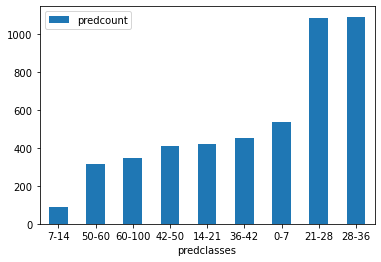

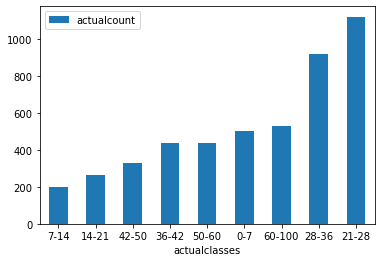

In [39]:
preddf.sort_values("predcount").plot.bar(x='predclasses',y='predcount',rot=0)
actualdf.sort_values("actualcount").plot.bar(x='actualclasses',y='actualcount',rot=0)